### Deep Learning - Project 21
#### Week 1:
This week we want to implement the first steps of the project. We want to understand and visualize the data and get acquainted with the TIF file. We want to try to use the U-net model on the small dataset that the professor gave (all images have a corresponding mask - fully supervised).

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, random_split, DataLoader
from scipy.ndimage import gaussian_filter
import torch.nn as nn

##### Step 1:
The images are TIF files with 32 bit depth and dimension 768x768. The TIF file does not compress the data, so it is lossless. The TIF file can be a 3D stack (a volume) but that is not the case. The following code allows to view the image from the TIF file and now some of its characteristics.

In [ ]:
# Choose what file to upload
from google.colab import files
uploaded = files.upload()

Saving image_v2_mask_00.tif to image_v2_mask_00.tif


Image dtype: float32
Min intensity: -0.0006558113
Max intensity: 0.00043277102
Mean intensity: 0.00011117623


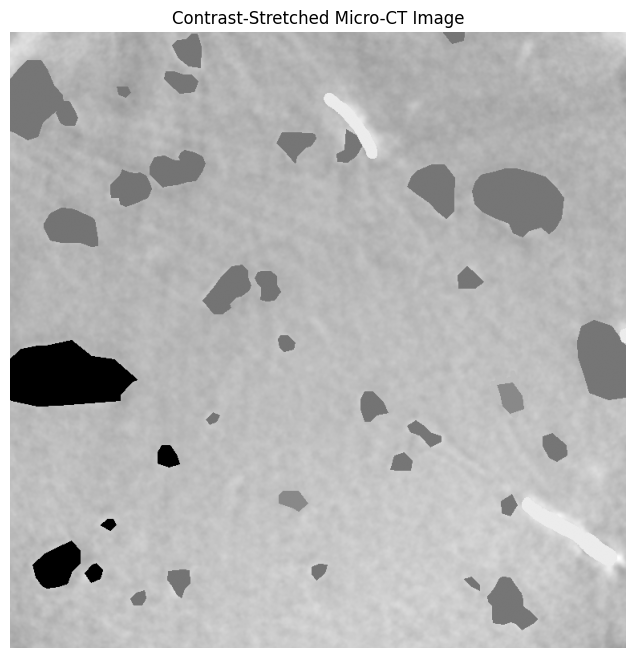

In [ ]:
# Get filename
filename = list(uploaded.keys())[0]

# Load image
img = tiff.imread(filename)

# Print intensity stats
print("Image dtype:", img.dtype)
print("Min intensity:", np.min(img))
print("Max intensity:", np.max(img))
print("Mean intensity:", np.mean(img))

# Stretch contrast manually
img_stretched = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
img_stretched = img_stretched.astype(np.uint8)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(img_stretched, cmap='gray')
plt.title("Contrast-Stretched Micro-CT Image")
plt.axis('off')
plt.show()

#### Step 2:
First we have to look at the SIMUPOR images that we are using to pre-train the u-net model. We have to preprocess them (normalize and denoise) and then do some data augmentation. Only after these steps we can create the model that extracts their features and does the segmentation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the main folder containing the three subfolders
main_folder = "/content/drive/MyDrive/SIMUPOR"

# List to hold all image tensors
image_list = []
mask_list = []

# Loop through sample folders
for folder_name in sorted(os.listdir(main_folder)):
    folder_path = os.path.join(main_folder, folder_name)

    if os.path.isdir(folder_path):
        images_path = os.path.join(folder_path, "images")
        masks_path = os.path.join(folder_path, "masks")

        # Ensure both folders exist
        if not (os.path.isdir(images_path) and os.path.isdir(masks_path)):
            continue

        # Get sorted image + mask filenames for alignment
        image_files = sorted(os.listdir(images_path))
        mask_files = sorted(os.listdir(masks_path))

        # Loop through images
        for img_file, mask_file in zip(image_files, mask_files):

            if img_file.lower().endswith(".png") and mask_file.lower().endswith(".npy"):

                img_path = os.path.join(images_path, img_file)
                mask_path = os.path.join(masks_path, mask_file)

                # Open and convert
                img = Image.open(img_path).convert("L")
                mask_array = np.load(mask_path)
                mask= Image.fromarray(mask_array)

                image_list.append(img)
                mask_list.append(mask)

print("Loaded:")
print("Images:", len(image_list))
print("Masks:", len(mask_list))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded:
Images: 256
Masks: 256


The list of masks and images are Image objects but we want to make them tensors (inspired by notebook 4.1. of Deep Learning Course).

In [ ]:
# Convert all images to tensors
to_tensor = transforms.ToTensor()
image_tensors = [to_tensor(img) for img in image_list]
mask_tensors = [to_tensor(mask) for mask in mask_list]

# Stack into big tensors
images = torch.stack(image_tensors)
masks  = torch.stack(mask_tensors)

# Matching images to masks (makes things easier)
simupor_dataset = TensorDataset(images, masks)
N = len(full_dataset)

# Spliting the data into training, validation and testing subsets
# The data was already splited in the folders, but this way we can make it 65 - 15 - 20
train_size = int(0.65 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(simupor_dataset, [train_size, val_size, test_size])

# We use DataLoaders like in notebook 4.1.
batch_size = 16 #we have 256 images, then we do 16 batches per epoch, so batch_size = 16
x_train, mask_train = next(iter(DataLoader(train_dataset, batch_size=batch_size, shuffle=True)))
x_val, mask_val     = next(iter(DataLoader(val_dataset, batch_size=batch_size, shuffle=True)))
x_test, mask_test   = next(iter(DataLoader(test_dataset, batch_size=batch_size, shuffle=False)))

print("Information on dataset:")
print("Shape of x_train:", x_train.shape)
print("Shape of mask_train:", mask_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of mask_val:", mask_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of mask_test:", mask_test.shape)

Information on dataset:
Shape of x_train: torch.Size([16, 1, 256, 256])
Shape of mask_train: torch.Size([16, 1, 256, 256])
Shape of x_val: torch.Size([16, 1, 256, 256])
Shape of mask_val: torch.Size([16, 1, 256, 256])
Shape of x_test: torch.Size([16, 1, 256, 256])
Shape of mask_test: torch.Size([16, 1, 256, 256])


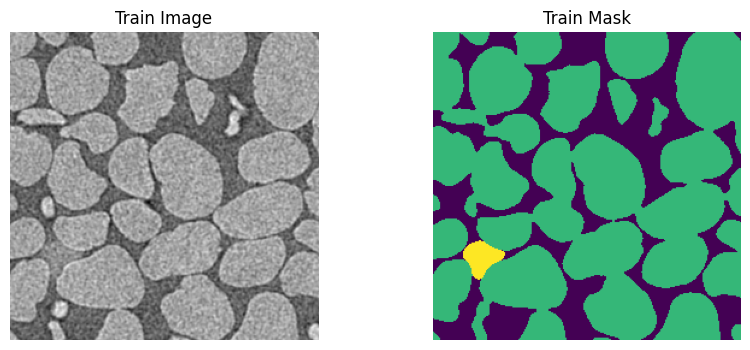

In [ ]:
# Choose the images
img = x_train[12].permute(1, 2, 0)   # CHW → HWC
mask = mask_train[12].squeeze()

# See the different values in the mask

mask_train[12].unique()

# Ploting
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Train Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Train Mask")
plt.axis("off")

plt.show()

Now that we have established the train/val/test subsets we can normalize and denoise the images (pre-processing tasks)

In [ ]:
def normalize_and_denoise(tensor, sigma=1.0):
    """
    Normalize a grayscale image tensor to [0,1] and apply Gaussian denoising.
    tensor: torch.Tensor of shape [C, H, W]
    sigma: standard deviation for Gaussian filter
    """
    # Convert to numpy for filtering
    img_np = tensor.squeeze(0).numpy()  # remove channel dim for processing

    # Min-max normalization
    img_norm = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    # Denoise using Gaussian filter
    img_denoised = gaussian_filter(img_norm, sigma=sigma)

    # Convert back to tensor and keep channel dimension
    return torch.tensor(img_denoised, dtype=torch.float32).unsqueeze(0)

# Apply to entire datasets
def process_dataset(tensor_dataset, sigma=1.0):
    processed_images = []

    for img in tensor_dataset:
        img_proc = normalize_and_denoise(img, sigma=sigma)
        processed_images.append(img_proc)

    # Stack into new TensorDataset
    new_images = torch.stack(processed_images)
    return torch.utils.data.TensorDataset(new_images)

# Process train, val, and test sets
train_dataset = process_dataset(x_train, sigma=1.0)
val_dataset   = process_dataset(x_val, sigma=1.0)
test_dataset  = process_dataset(x_test, sigma=1.0)

print("Datasets normalized and denoised.")

Datasets normalized and denoised.


AttributeError: 'tuple' object has no attribute 'permute'

##### Step 3:
Now we can start creating the U-net model (taken from https://debuggercafe.com/unet-from-scratch-using-pytorch/). It is important that we use a editable model, because the input images are in grayscale.

In [ ]:

def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out

In [ ]:
# Defining main model characteristics
model = UNet(num_classes = 3)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
print(model)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(51